# Deep Learning Project (DD2424)


## -- INITIAL SETUP --

### 0.1 Download datasets

In [66]:
download_data = False

In [67]:
if download_data:
    !wget https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
    !wget https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz

    !mkdir oxford-iiit-pet/
    !tar -xf images.tar.gz -C oxford-iiit-pet/
    !tar -xf annotations.tar.gz -C oxford-iiit-pet/
    !rm images.tar.gz
    !rm annotations.tar.gz

else:
    print("Note: Assuming that data is manually downloaded!")
    # --> Alternative is to manually download datasets here: https://www.robots.ox.ac.uk/~vgg/data/pets/
    #  Note: must have the folder "oxford-iiit-pet" in same directory as code/notebook

Note: Assuming that data is manually downloaded!


### 0.2 Define Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import torchvision

from torchvision.io import read_image
from torchvision.transforms import ToTensor
from torchvision.ops.boxes import masks_to_boxes

from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision.transforms import transforms

### 0.3 Example plot

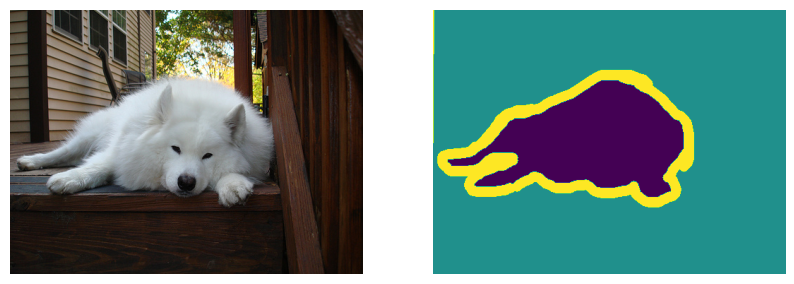

In [3]:
from torchvision.io import read_image

# -- PLOT EXAMPLE IMAGE AND MASK --
name = 'samoyed_142'
img = read_image(f'oxford-iiit-pet/images/{name}.jpg')
mask = read_image(f'oxford-iiit-pet/annotations/trimaps/{name}.png')

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.subplot(122)
plt.imshow(mask.permute(1, 2, 0))
plt.axis('off')
plt.show()

## -- DATA PREPROCESSING --


### 1.1 Define datasets and dataloaders and subset splits (train, validation, test):

In [57]:
# --------- Transform pipeline ---------

def transform_pipeline(in_data):
    # Define an ordered collection of functions/transformations to apply to all images
    pipeline = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float),
    ])
    return pipeline(in_data)

def load_dataset():
    # Load in all the data within file 'trainval.txt'
    dataset = OxfordIIITPet(
    root='.',
    download=False,
    transform=transform_pipeline,
    target_transform=target_transform,   # TODO: Figure out what this is and why the 'target_transform' function returns it's input
    target_types=["binary-category"],
    )
    return dataset

def target_transform(target):
    #cat_classes = {6, 34, 12, 27, 33, 7, 24, 21, 10, 28, 1, 8}  # set lookup is faster
    #return 0 if target in cat_classes else 1
    return target   # if we use ["binary-category"]

def create_split_idxs(n_tot, f_train=0.8, f_valid=0.1, f_test=0.1):

    if f_train + f_valid + f_test > 1:
        print("ERROR: FACTORS TOO LARGE TO CREATE SPLITS, TRY AGAIN")

    # Range from index 0 to n==len(dataset)
    idxes = np.arange(n_tot)
    np.random.seed(42)   # random seed to ensure repeatability
    np.random.shuffle(idxes)

    # split limits:
    s1 = int(n_tot*f_train)
    s2 = int(n_tot*(f_train+f_valid))

    # Create index lists
    train_idx = idxes[:s1]
    val_idx = idxes[s1:s2]
    test_idx = idxes[s2:]

    return train_idx, val_idx, test_idx


def get_dataloaders(n_batch, f_train=0.8, f_valid=0.1, f_test=0.1):
    # Load in all data
    dataset = load_dataset()

    # Test it
    image, label = dataset[0]
    print(f"Image shape: {image.shape}")


    # Create shuffled index splitting for each subset
    train_idx, val_idx, test_idx = create_split_idxs(len(dataset), f_train, f_valid, f_test)

    # Split using imported Subset class
    dataset_train = Subset(dataset, train_idx)
    dataset_test = Subset(dataset, test_idx)
    dataset_val = Subset(dataset, val_idx)

    # Create data loader containing datasets
    dataloader_train = DataLoader(dataset_train, batch_size=n_batch, shuffle=True, num_workers=2)
    dataloader_test = DataLoader(dataset_test, batch_size=n_batch, shuffle=False, num_workers=2)
    dataloader_val = DataLoader(dataset_val, batch_size=n_batch, shuffle=True, num_workers=2)

    return dataloader_train, dataloader_test, dataloader_val


### 1.2 Plot random example images to show pre-processing (scaling and cropping)

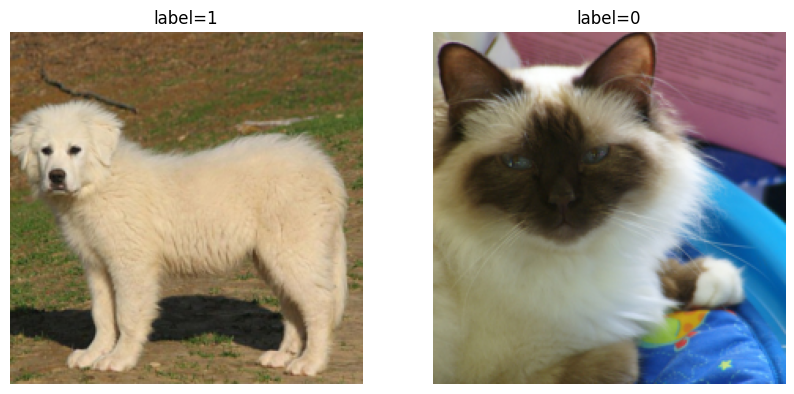

In [5]:
dataset = load_dataset()

#print(len(dataset[0]))

# plot example image
plt.figure(figsize=(10, 10))
plt.subplot(121)

dog = 2600
plt.imshow(dataset[dog][0].permute(1, 2, 0))
plt.axis('off')
plt.title(f"label={dataset[dog][1]}")
plt.subplot(122)

cat = 300
plt.imshow(dataset[cat][0].permute(1, 2, 0))
plt.title(f"label={dataset[cat][1]}")

plt.axis('off')

plt.show()


### (maybe todo) 1.3 Define zero-mean normalization across all data

In [72]:
def zero_mean(dataloader):
    # TODO: FIXME IF WE WANT TO DO ZERO MEAN NORMALIZATION

    #print(next(iter(dataloader_test))[0].shape)  # torch.Size([64, 3, 224, 224])
    #img = next(iter(dataloader_test))[0][0]
    #print(img.max())
    #print(img.min())
    #print(max(next(iter(dataloader_test))))

    img, _ = next(iter(dataloader))
    img = img[0]
    print(f'max: {torch.max(img)}')
    print(f'min: {torch.min(img)}')
    print(f'mean: {torch.mean(img)}')


## -- NETWORK SETUP --

### 2.0 Network Imports

In [6]:
from torchvision.models import resnet18
from torchvision.models import resnet34
from torchvision.models import resnet50
from torchvision.models import resnet101
from torchvision.models import wide_resnet50_2
#from torchvision.models import resnet152

import ssl
ssl._create_default_https_context = ssl._create_unverified_context


### 2.1 Define model and training functions

In [8]:
def create_model_and_optim(choice="resnet34", lr=0.001, wd=0.0005):

    # Load in pretrained model of our choice:
    if choice == "resnet18":
        model = resnet18(weights='DEFAULT')   # Using best (pretrained?) weights with "DEFAULT"
    elif choice == "resnet34":
        model = resnet34(weights='DEFAULT')   # Using best (pretrained?) weights with "DEFAULT"
    elif choice == "resnet50":
        model = resnet50(weights='DEFAULT')   # Using best (pretrained?) weights with "DEFAULT"
    elif choice == "resnet101":
        model = resnet101(weights='DEFAULT')   # Using best (pretrained?) weights with "DEFAULT"
    else:
        print("model choice does not match")
        exit()

    # As instructed, only replace final layer with same in but one out (cat/dog)
    in_features = model.fc.in_features   # size of input of final layer --> 512
    #print(model.fc.out_features)   # size of output into final layer --> 1000

    # Create a new Linear layer to replace last fc layer with:
    model.fc = torch.nn.Linear(in_features, 1)  # for binary classification instead of outputting 1000

    # Freeze all layers before final layer which we will replace
    for param in model.parameters():
        param.requires_grad = False

    for param in model.fc.parameters():
        param.requires_grad = True   # update these layer weights (only last)

    optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr, weight_decay=wd)
    # TODO: maybe look into NAG as alternative

    return model, optimizer


def train(model, dataloader, optimizer, epochs=1):
    losses = []

    model = model.to(device)

    model.train()  # tells model we will train now maybe
    criterion = torch.nn.BCEWithLogitsLoss()
    # trains in batches
    for _ in range(epochs):

        running_loss = 0.0

        # for each batch:
        for i, (img, binary_category) in enumerate(dataloader):

            #print(img.shape)  # torch.Size([64, 3, 224, 224])

            img = img.to("cuda")
            binary_category = binary_category.to("cuda")

            # Forward pass of network
            output = model(img)

            # Compute loss
            # TODO: check if we want to use another loss function
            loss = criterion(output, binary_category.view(-1, 1).float())

            # Compute gradients
            loss.backward()

            # Backprop
            optimizer.step()  # update weights with grads

            batch_loss = loss.item()

            losses.append(batch_loss)
            running_loss += batch_loss

            print(f"\r{i} : {batch_loss}", end="")

            optimizer.zero_grad()  # reset grads

    return losses


### 2.2 Define metrics

In [70]:
# TODO: FIXME
def compute_accuracy(model, dataloader_test):
    total = 0
    correct = 0

    # no grad so it's faster (--> Julia edit: 'no_grad()' ensures that we can calculate with tensors without affecting it's gradients in backprop)
    with torch.no_grad():

        model.eval()

        for i, (img, binary_category) in enumerate(dataloader_test):
            img = img.to("cuda")
            binary_category = binary_category.to("cuda").view(-1, 1)

            output = model(img)
            prediction = torch.round(torch.sigmoid(output))

            #print(output.shape)  # torch.Size([16, 1])
            #print(prediction.shape) # torch.Size([16, 1])
            #print(binary_category.shape)  # torch.Size([16])

            total += binary_category.size(0)

            correct_i = (prediction == binary_category)
            #print(correct_i.shape)
            #print(correct_i)

            #print(correct_j)
            #print(" ")

            correct_j =correct_i.sum().item()
            correct += correct_i.sum().item()

            if i % 10 == 0:
                print(f'\nAccuracy: {100 * correct / total} %')
        print(f'\nAccuracy: {100 * correct / total} %')


def compute_confusion_matrix():
    pass


### 2.3 Define plotting functions

## -- NETWORK TRAINING --

### 2.3 Initialize data

In [71]:
dataloader_train, dataloader_test, dataloader_val = get_dataloaders(n_batch=32, f_train=0.7, f_test=0.1, f_valid=0.2)

print("done loading data")
print("number of batches:", len(dataloader_train))

Image shape: torch.Size([3, 224, 224])
done loading data
number of batches: 161


### 2.3 Initialize model, train, and plot losses

In [62]:
print(f"cuda == {torch.cuda.is_available()}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model, optimizer = create_model_and_optim(choice="resnet34", lr=0.001, wd=0.0005)


cuda == True


In [63]:
#print(torch.cuda.get_device_name(0))  # Tesla P4

print("Start training")
losses = train(model, dataloader_train, optimizer, epochs=1)


Start training
137 : 0.10588935762643814

### 2.4 Evaluate and plot losses

In [51]:
def smooth(y, box_pts=10):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def plot_losses(losses):
    #losses_cpu = [loss.cpu().detach().numpy() for loss in losses]
    losses_cpu = [loss for loss in losses]
    #plt.plot(smooth(losses_cpu))
    plt.plot(losses_cpu)
    plt.xlabel("batch nr")
    plt.ylabel("training loss")


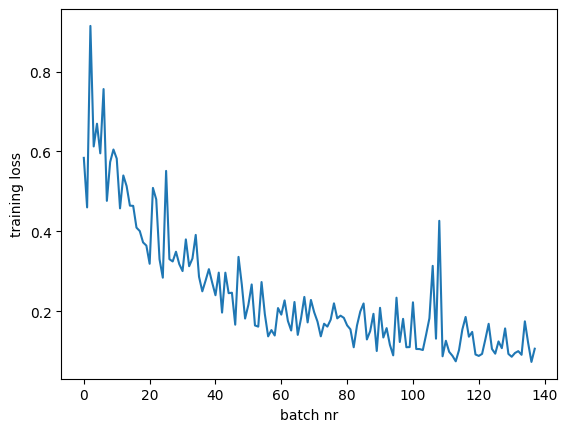

In [66]:
plot_losses(losses)


In [69]:
compute_accuracy(model, dataloader_test)


Accuracy: 100.0 %

Accuracy: 98.2312925170068 %


### 2.

### 2.

### 2.

### 2.

### 2.